In [1]:
#Install librariesc

In [1]:
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install openpyxl
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install regex
!{sys.executable} -m pip install graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [3]:
#Import libraries

In [5]:
import matplotlib as mp
import pandas as pd
import numpy as np
import scipy.stats as st
import pprint
import seaborn as sb
import re
import logging
import graphviz
import time as t

# Question 1 : Build Decision Tree for 'tennis dataset'

#### data set

In [6]:
raw_tennis_data = {'Outlook' : ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain','Rain','Overcast','Sunny','Sunny','Rain','Sunny','Overcast','Overcast','Rain'],
                    'Temp.' : ['Hot','Hot','Hot','Mild','Cool','Cool','Cool','Mild','Cool','Mild','Mild','Mild','Hot','Mild'],
                    'Humidity' : ['High','High','High','High','Normal','Normal','Normal','High','Normal','Normal','Normal','High','Normal','High'],
                    'Wind' : ['Weak','Strong','Weak','Weak','Weak','Strong','Strong','Weak','Weak','Weak','Strong','Strong','Weak','Strong'],
                    'Play' : ['No','No','Yes','Yes','Yes','No','Yes','No','Yes','Yes','Yes','Yes','Yes','No']}
df_tennis = pd.DataFrame(data=raw_tennis_data)
raw_tennis_test = {'Outlook' : ['Sunny', 'Sunny'],
                   'Temp.' : ['Cool','Mild'],
                   'Humidity' : ['Normal','Normal'],
                   'Wind' : ['Weak','Weak'],
                   'Play' : ['Yes','Yes']}
df_tennis_test = pd.DataFrame(data=raw_tennis_test)

#### Function that calculate entropy

In [7]:
def Entropy(df, target_name):
    entropy = 0
    elements, num = np.unique(df[target_name], return_counts = True)
    for i in range(len(elements)):
        entropy += -(num[i]/np.sum(num))*np.log2(num[i]/np.sum(num))
        
    return entropy

#### Entropy for an attribute

In [8]:
def InformationGain(df, attribute_name, target_name, threshold = 0):
    total_entropy = Entropy(df, target_name)
    entropy = 0
    att_elements, att_num = np.unique(df[attribute_name], return_counts = True)
    
    if len(att_elements) > 5:
        smaller = df[(df[attribute_name] < threshold)]
        greater = df[(df[attribute_name] >= threshold)]
    
        entropy = (len(smaller)/len(df))*Entropy(smaller, target_name) + (len(greater)/len(df))*Entropy(greater, target_name)
    
    else:
        for i in range(len(att_elements)):
            att_col = df[attribute_name]
            filtered = (att_col==att_elements[i])
            entropy += (att_num[i]/np.sum(att_num))*Entropy(df[filtered], target_name)
        
    return total_entropy-entropy

#### Splitting continuous attributes

In [9]:
def Threshold(df, att_name, target_name):
    sroted = df.sort_values(by=[att_name])
    pivots = df[df[target_name] != df[target_name].shift(-1)]
    thresholds = []
    pivots = pivots[:-1]
    for i in pivots.index:
        t = (float(df[att_name].values[i]) + float(df[att_name].values[i+1]))/2.0
        if t not in thresholds:
            thresholds.append(t)

    IGs = []
    for t in thresholds:
        IGs.append(InformationGain(df, att_name, target_name, t))

    highest = np.argmax(IGs)

    return thresholds[highest]

#### Classification

In [10]:
def Classify(df, target_name):
    elements, num = np.unique(df[target_name], return_counts = True)
    
    max_index = np.argmax(num)
    
    return elements[max_index]

#### DecisionTree function

In [11]:
def DecisionTree(df, original, target_name, continuous_att_list, depth, max_depth=-1, instance_min = 0):

    df_features = df.drop(columns=[target_name])
    
    if len(df)==0 or len(df_features.columns)==0: #no instances or no features
        return Classify(original, target_name)
    
    if len(df)<=instance_min or depth == max_depth: #limit of number of instances or depth
        return Classify(df, target_name)

    if len(np.unique(df[target_name])) <= 1: #pure node
        return Classify(df, target_name)
    
    if len(df_features.columns)==1 and len(np.unique(df_features[df_features.columns[0]]))==1:
        return Classify(original, target_name)

    #Calculate all information gains for attributes
    IGs = []
    thresholds = []
    for att in df_features.columns:
        if att in continuous_att_list :
            t = Threshold(df, att, target_name)
            thresholds.append(t)
            IG = InformationGain(df,att,target_name,t)
            IGs.append(IG)
        else:
            thresholds.append(None)
            IG = InformationGain(df,att,target_name)
            IGs.append(IG)
        
    #Pick highest IG
    highest = np.argmax(IGs)
    att_name = df_features.columns[highest]
    selected_att = df[att_name]
    
    #Handle continuous attribute
    if att_name in continuous_att_list:
        threshold = thresholds[highest]
        key = "{} < {}".format(att_name, threshold)
        tree = {key:{}}
        smaller = df[(df[att_name]) < threshold].drop(columns=att_name).reset_index(drop=True)
        greater = df[(df[att_name]) >= threshold].drop(columns=att_name).reset_index(drop=True)

        tree[key]['Yes'] = DecisionTree(smaller, df, target_name, continuous_att_list,depth+1, max_depth,instance_min)
        tree[key]['No'] = DecisionTree(greater, df, target_name, continuous_att_list,depth+1, max_depth,instance_min)
        
    #Binary attribute
    else:
        tree = {att_name:{}}
        for val in np.unique(selected_att):
            df_sub = df[(selected_att==val)].drop(columns=att_name).reset_index(drop=True)
            tree[att_name][val] = DecisionTree(df_sub, df, target_name, continuous_att_list,depth+1, max_depth,instance_min)
            

    return tree

#### predict and print the accuracy

In [12]:
def Predict(tree, row):
    
    key = list(tree.keys())[0]
    
    next_tree = {}
    
    #handle the continuous attributes
    if len(re.findall('<',key)) >= 1:
        att_name, operator, value = key.split(' ')
        if row[att_name][row.index.start] < float(value):
            next_tree = tree[key]['Yes']
        else:
            next_tree = tree[key]['No']
    #binary attributes
    else:
        next_tree = tree[key][row[key][row.index.start]]

    if isinstance(next_tree, dict):
        return Predict(next_tree, row)
    else:
        return next_tree


#### predict with test dataset and print accuracy

In [13]:
def Test(tree, test_data, target_name):
    correct = 0
    for i in range(len(test_data.index)):
        row = test_data[i:i+1]
        result = Predict(tree, row)
        if result==row[target_name][row.index.start]:
            correct += 1
    accuracy = correct/len(test_data.index)
    print('< Accuracy =',accuracy*100,'% >')
    return accuracy*100.0

#### Function for dot the node of tree

In [14]:
def digraph(g, tree, parent, edge_label, node_id):
    
    if not isinstance(tree,dict):
        key = '{}'.format(tree)
        g.node(node_id,label=key, style='filled', shape='box')
        if parent:
            g.edge(parent, node_id, label=edge_label)
        return
    
    key = '{}'.format(list(tree.keys())[0])
    
    if parent :
        g.node(node_id,label=key, shape='ellipse', style= '')
        g.edge(parent, node_id, label=edge_label)
        parent = node_id
    else:
        g.node(node_id,label=key)
        parent = node_id
    
    values = tree[key]
    for val in list(values.keys()):
        digraph(g, tree[key][val], parent, '{}'.format(val), '{}_{}'.format(node_id, val))


#### Visualization using above 'digraph'

In [15]:
def Visualization(tree):
    g = graphviz.Digraph('Decision Tree')

    digraph(g, tree, None, None, 'R')
    display(g)

#### Build and test the tennis set

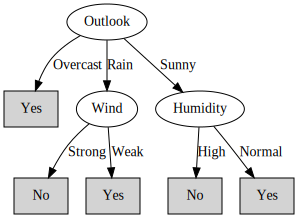

< Accuracy = 100.0 % >


100.0

In [25]:
tree = DecisionTree(df_tennis, df_tennis, 'Play', [], 0)
Visualization(tree)
Test(tree, df_tennis_test, 'Play')

# Question 2 : Build Decision Tree for 'Personal Loan Data'

In [16]:
df = pd.read_excel("Personal Loan Data.xlsx", 'Data')
df = df.drop(columns=['ID','ZIP Code'])
continuous = ['Age','Experience','Income','CCAvg','Mortgage','Family','Education']
#print(df)

#### Drop the duplicates cases and empty cases

In [18]:
df = df.drop_duplicates(subset=df.columns, ignore_index=True)
#print(df)
df = df.dropna()
df = df.reset_index(drop=True)
print(df)

      Age  Experience  Income  Family  CCAvg  Education  Mortgage  \
0      25           1      49       4    1.6          1         0   
1      45          19      34       3    1.5          1         0   
2      39          15      11       1    1.0          1         0   
3      35           9     100       1    2.7          2         0   
4      35           8      45       4    1.0          2         0   
...   ...         ...     ...     ...    ...        ...       ...   
4982   29           3      40       1    1.9          3         0   
4983   30           4      15       4    0.4          1        85   
4984   63          39      24       2    0.3          3         0   
4985   65          40      49       3    0.5          2         0   
4986   28           4      83       3    0.8          1         0   

      Personal Loan  Securities Account  CD Account  Online  CreditCard  
0                 0                   1           0       0           0  
1                 0    

#### Using z score, check outlier

In [19]:
z_score = st.zscore(df.drop(columns=['Personal Loan']))
#print(z_score)

#print(abs_z)
filtered = (np.abs(z_score)< 3).all(axis=1)
df = df[filtered].reset_index(drop=True)
print(df)

      Age  Experience  Income  Family  CCAvg  Education  Mortgage  \
0      25           1      49       4    1.6          1         0   
1      45          19      34       3    1.5          1         0   
2      39          15      11       1    1.0          1         0   
3      35           9     100       1    2.7          2         0   
4      35           8      45       4    1.0          2         0   
...   ...         ...     ...     ...    ...        ...       ...   
4496   29           3      40       1    1.9          3         0   
4497   30           4      15       4    0.4          1        85   
4498   63          39      24       2    0.3          3         0   
4499   65          40      49       3    0.5          2         0   
4500   28           4      83       3    0.8          1         0   

      Personal Loan  Securities Account  CD Account  Online  CreditCard  
0                 0                   1           0       0           0  
1                 0    

#### Heatmap correlation

In [21]:
def correlation(df):
    drop=[]
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if(np.abs(corr_matrix.iloc[i,j]) > 0.95) and (corr_matrix.columns[j] not in drop):
                drop.append(corr_matrix.columns[i])
                
    return drop

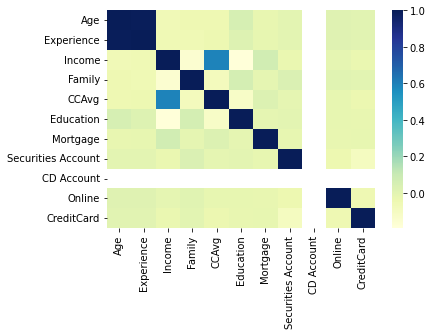

['Experience']
                    Personal Loan
Experience               0.018628
Age                      0.020066
Mortgage                 0.038681
Family                   0.042367
Online                   0.042741
Securities Account       0.047853
CreditCard               0.070205
Education                0.118272
CCAvg                    0.332940
Income                   0.446510
Personal Loan            1.000000
CD Account                    NaN


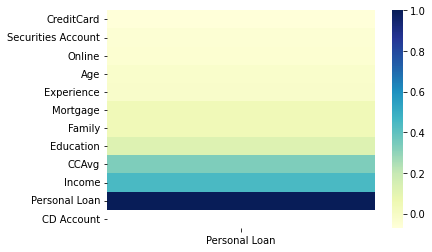

['Experience', 'CD Account']


In [22]:
dataplot_feature = sb.heatmap(df.drop(columns=['Personal Loan']).corr(), cmap="YlGnBu")
mp.pyplot.show()

to_drop = correlation(df.drop(columns=['Personal Loan']))
print(to_drop)


corr_target = df.drop(columns=['Personal Loan']).corrwith(df['Personal Loan'])
print(np.abs(df.corr()[['Personal Loan']]).sort_values('Personal Loan'))
dataplot_target = sb.heatmap(df.corr()[['Personal Loan']].sort_values('Personal Loan'), cmap="YlGnBu")
mp.pyplot.show()

for index in corr_target.index:
    if pd.isna(corr_target[index]):
        to_drop.append(index)
    if np.abs(corr_target[index]) < 0.01 and index not in to_drop:
        print('to_drop: ', index, corr_target[index])
        to_drop.append(index)
        
print(to_drop)
df_dropped=df.drop(columns=to_drop)


#### Split the dataset into training set and test set

In [23]:
pivot = round(len(df_dropped) * 0.8)
df_test = df_dropped[pivot:]
print(len(df_test))
df_training = df_dropped[:pivot]
print(len(df_training))

900
3601


#### Build decision Tree without depth limit and instnace limit
#### Test with test dataset

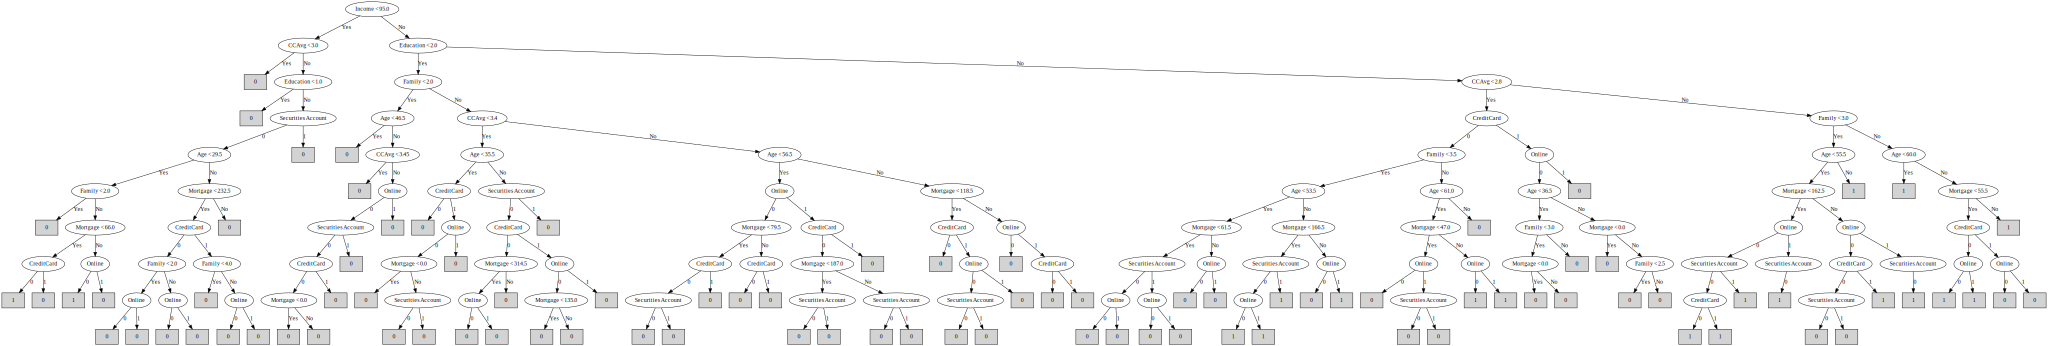

96.22222222222221

< Accuracy = 96.22222222222221 % >


In [24]:
loan_tree = DecisionTree(df_training, df_training,'Personal Loan', continuous, 0)
Visualization(loan_tree)
Test(loan_tree, df_test, 'Personal Loan')

#### Tree Pruning
* 1. Halt when the depth of the tree goes beyond a predefined limit
* 2. Halt when the number of instances is less than some user-specified threshold

* Compare the overall accuracy
* before pruning : accuracy = 96.2222%
* after pruning : accuracy = 96.5556%

#### Analyze and explain

* The best depth limit : 4
* depth 4 : accuracy = 96.5556%
* depth 5 : accuracy = 96.5556%
* depth 6 : accuracy = 96%
* depth 7 : accuracy = 96.111%

#### Pruning 1 : Decision tree with limited Depth

[DEBUG@graphviz.backend] run ['dot', '-Kdot', '-Tsvg']


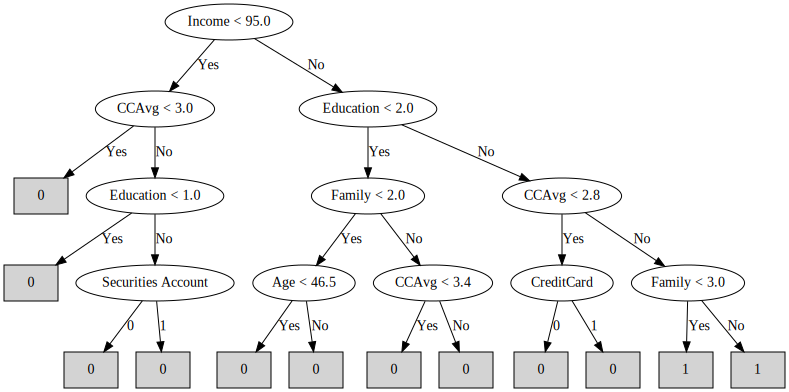

< Accuracy = 96.55555555555554 % >


96.55555555555554

In [66]:
tree_depth_4 = DecisionTree(df_training, df_training,'Personal Loan', continuous, 0, max_depth=4)
Visualization(tree_depth_4)
Test(tree_depth_4, df_test, 'Personal Loan')

#### Pruning 2 : limit the number of intances

[DEBUG@graphviz.backend] run ['dot', '-Kdot', '-Tsvg']


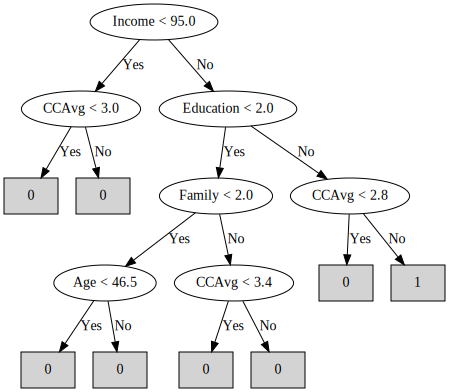

< Accuracy = 96.55555555555554 % >


96.55555555555554

In [67]:
tree_instance_threshold = DecisionTree(df_training, df_training,'Personal Loan', continuous, 0 , instance_min = 200)
Visualization(tree_instance_threshold)
Test(tree_instance_threshold, df_test, 'Personal Loan')

#### Apply both pruning

[DEBUG@graphviz.backend] run ['dot', '-Kdot', '-Tsvg']


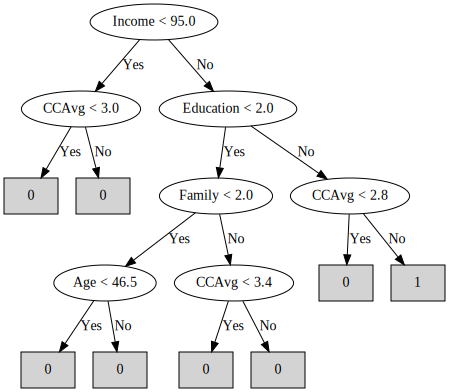

< Accuracy = 96.55555555555554 % >


96.55555555555554

In [68]:
#apply both
tree_depth_instance = DecisionTree(df_training, df_training,'Personal Loan', continuous, 0 ,max_depth=4, instance_min = 200)
Visualization(tree_depth_instance)
Test(tree_depth_instance, df_test, 'Personal Loan')

#### Draw graph

In [95]:
i = 100
number_training = []
accuracy = []
times = []
while i < len(df_training):
    start = t.time()
    training_tree = DecisionTree(df_training[:i], df_training[:i], 'Personal Loan', continuous, 0, max_depth = 4)
    #Visualization(training_tree)
    times.append(t.time()-start)
    accuracy.append(Test(training_tree,df_test, 'Personal Loan'))
    number_training.append(i)
    i += 100

< Accuracy = 98.0 % >
< Accuracy = 98.0 % >
< Accuracy = 95.66666666666667 % >
< Accuracy = 96.11111111111111 % >
< Accuracy = 97.22222222222221 % >
< Accuracy = 96.88888888888889 % >
< Accuracy = 97.11111111111111 % >
< Accuracy = 97.11111111111111 % >
< Accuracy = 96.44444444444444 % >
< Accuracy = 96.55555555555554 % >
< Accuracy = 97.0 % >
< Accuracy = 97.0 % >
< Accuracy = 97.0 % >
< Accuracy = 96.55555555555554 % >
< Accuracy = 96.77777777777777 % >
< Accuracy = 96.77777777777777 % >
< Accuracy = 96.55555555555554 % >
< Accuracy = 96.55555555555554 % >
< Accuracy = 96.55555555555554 % >
< Accuracy = 96.55555555555554 % >
< Accuracy = 96.55555555555554 % >
< Accuracy = 96.55555555555554 % >
< Accuracy = 96.77777777777777 % >
< Accuracy = 96.55555555555554 % >
< Accuracy = 96.55555555555554 % >
< Accuracy = 96.55555555555554 % >
< Accuracy = 97.0 % >
< Accuracy = 97.0 % >
< Accuracy = 97.0 % >
< Accuracy = 97.0 % >
< Accuracy = 97.0 % >
< Accuracy = 96.77777777777777 % >
< Accuracy

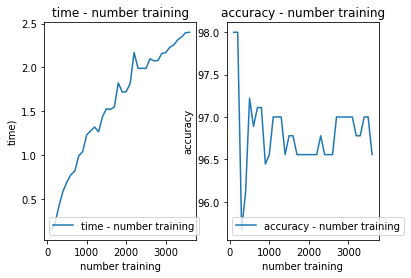

In [97]:
fig = mp.pyplot.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.plot(number_training, times, label='time - number training')
ax2.plot(number_training, accuracy, label='accuracy - number training')
ax1.set_xlabel('number training')
ax1.set_ylabel('time)')
ax1.set_title('time - number training')
ax1.legend()
ax2.set_xlabel('number training')
ax2.set_ylabel('accuracy')
ax2.set_title('accuracy - number training')
ax2.legend()

mp.pyplot.show()

####  Number of training samples / performance
* By increasing the number of training samples, accuracy is getting close to some value (in this case, 96.5556%)
* By increasing the number of training samples, time increases because it will take more time.